## Notebook showing example of plotting demand against supply


In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import sys
import json


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import patientflow

PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'work' / 'zella'


model_file_path = USER_ROOT / 'patientflow' / 'trained-models'
# model_file_path.mkdir(parents=True, exist_ok=True)
data_path = USER_ROOT / 'patientflow' / 'data-raw'
media_file_path = USER_ROOT / 'patientflow' / 'notebooks' / 'img'
# media_file_path.mkdir(parents=True, exist_ok=True)



In [3]:
from patientflow.viz.prob_dist_plot import prob_dist_plot
from patientflow.viz.pipeline_plots import create_colour_dict
spec_colour_dict = create_colour_dict()
figsize_global = (6,4)


### Create fictional distributions

In [5]:
import numpy as np
import pandas as pd
from scipy.stats import poisson
from scipy.signal import convolve

# Parameters for the Poisson distributions
size = 50    # Size of the distributions

# Generate the Poisson distributions
x = np.arange(size)
poisson1 = poisson.pmf(x, 2) # in ED now
poisson2 = poisson.pmf(x, 3) # yta
poisson3 = poisson.pmf(x, 12) # discharges

# Create DataFrames for each Poisson distribution
ed = pd.DataFrame(data={'agg_proba': poisson1}, index=x)
yta = pd.DataFrame(data={'agg_proba': poisson2}, index=x)

# Function to compute the combined probabilities
def compute_combined_probabilities(df1, df2, add = True):
    combined_probs = {}
    for i in df1.index:
        # print(i)
        for j in df2.index:
            if add:
                new_index = i + j
            else:
                new_index = i - j
            prob = df1.loc[i, 'agg_proba'] * df2.loc[j, 'agg_proba']
            # print(j)
            # print(combined_probs)
            if new_index in combined_probs:
                combined_probs[new_index] += prob
            else:
                combined_probs[new_index] = prob
    
    return pd.DataFrame(list(combined_probs.items()), columns=['index', 'agg_proba']).set_index('index').sort_index()

# Compute the combined probabilities
demand = compute_combined_probabilities(ed, yta, add = True)

supply = pd.DataFrame(data={'agg_proba': poisson3}, index=x)
netposition_supply = compute_combined_probabilities(supply, demand, add = False)
netposition_demand = compute_combined_probabilities(demand, supply, add = False)



In [6]:
directory_path = media_file_path / 'supply_demand_examples'
directory_path.mkdir(parents=True, exist_ok=True)
directory_path

PosixPath('/home/jovyan/work/zella/patientflow/notebooks/img/supply_demand_examples')

## Define functions

In [8]:
from matplotlib import pyplot as plt
import numpy as np
import itertools
from patientflow.predict.realtime_demand import index_of_sum


# def prob_dist_plot(prob_dist_data, title_, directory_path = None, figsize = (6,3), include_titles = False, truncate_at_beds=None, text_size = None, bar_colour='#5B9BD5', file_name = None, 
#                    plot_min_beds_lines = False, plot_bed_base = None, cdf_cut_points = [0.9, 0.7]):
            
    
#     min_beds_lines = {}

#     for cut_point in cdf_cut_points: 
        
#         min_beds_lines[cut_point] = index_of_sum(prob_dist_data.values, cut_point)
        
#     plt.figure(figsize=figsize)
    
#     if not file_name:
#         file_name = title_.replace(' ', '_').replace('/n', '_').replace('%', 'percent') + '.png'
#     plt.bar(prob_dist_data.index, 
#             prob_dist_data['agg_proba'],
#             color=bar_colour)
#     if truncate_at_beds:
#         plt.xlim(-0.5, truncate_at_beds + 0.5)
#     # plt.xticks(np.arange(0, truncate_at_beds + 1, 5))  # Set x-axis ticks at every 5 units

#     if plot_min_beds_lines:

#         colors = itertools.cycle(plt.cm.gray(np.linspace(0.3, 0.7, len(min_beds_lines))))
        
#         for point in min_beds_lines:
#             plt.axvline(x=prob_dist_data.index[min_beds_lines[point]], linestyle='--', linewidth=2, color=next(colors), label=f'{point*100:.0f}% probability')

#         plt.legend(loc='upper right', fontsize = 14 )
        
#     if plot_bed_base:
        
#         colors = itertools.cycle(plt.cm.gray(np.linspace(0.3, 0.7, len(min_beds_lines))))

#         for point in plot_bed_base:
#             plt.axvline(x=plot_bed_base[point], 
#                         # linestyle='--',
#                         linewidth=2, color='red', label=f'bed balance')
            
#         plt.legend(loc='upper right', fontsize = 14 )
    
#     if text_size:

#         plt.tick_params(axis='both', which='major', labelsize=14)
#         plt.xlabel('Number of beds', fontsize = text_size)

#     plt.tight_layout()
    
#     if directory_path:
#         plt.savefig(directory_path / file_name.replace(' ','_'), dpi=300)
#     plt.show()

## To plot with cdf lines

In [21]:
min_beds_lines = {}
cdf_cut_points=[0.7, 0.9]

for cut_point in cdf_cut_points: 
    min_beds_lines[cut_point] = index_of_sum(prob_dist_data.values, cut_point)

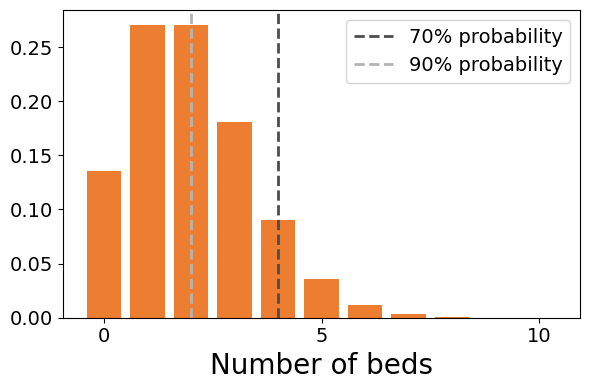

In [45]:
prob_dist_plot(prob_dist_data=ed.loc[0:10], title='Patients in ED', 
                   directory_path=directory_path, 
               figsize=figsize_global, 
               text_size=20, 
                   # file_name = 'Figure c', 
                   truncate_at_beds = 10,

              bar_colour = spec_colour_dict['single']['medical'],
              min_beds_lines=min_beds_lines
              )

## Plots without cdf lines

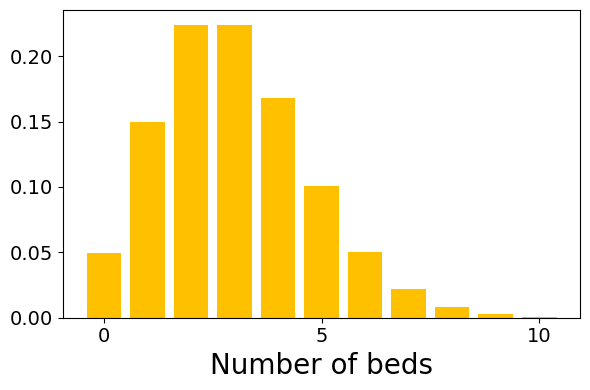

In [46]:

prob_dist_plot(prob_dist_data=yta.loc[0:10], title='Patients yet to arrive', 
               directory_path=directory_path, 
           figsize=figsize_global, 
           text_size=20,                    # file_name = 'Figure c', 
               truncate_at_beds = 12,
              bar_colour = spec_colour_dict['single']['haem/onc'])

<Figure size 600x300 with 0 Axes>

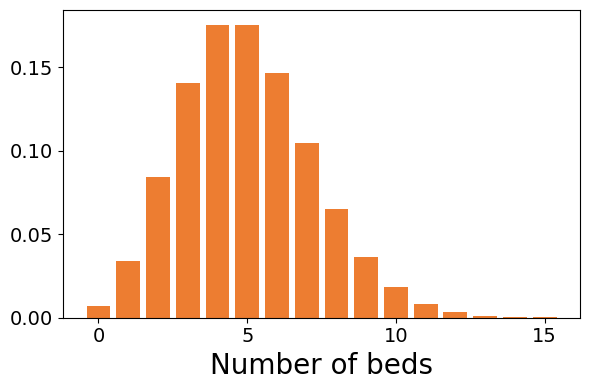

In [47]:
prob_dist_data = demand
plt.figure(figsize=(6,3))
truncate_at_ = 40

prob_dist_plot(prob_dist_data=demand.loc[0:15], title='Total demand', 
                   directory_path=directory_path, 
               figsize=figsize_global, 
               text_size=20,                    # file_name = 'Figure c', 
                   truncate_at_beds = 15,
                  bar_colour = spec_colour_dict['single']['medical'])

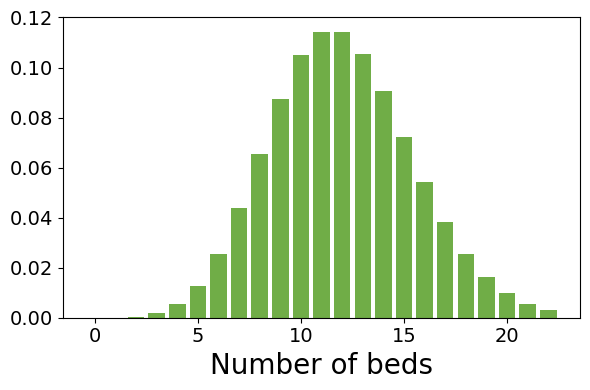

In [48]:
prob_dist_plot(prob_dist_data=supply.loc[0:22], title='Discharges', 
                   directory_path=directory_path, 
               figsize=figsize_global, 
               text_size=20,                    # file_name = 'Figure c', 
                   truncate_at_beds = 22,
                  bar_colour = spec_colour_dict['single']['surgical'])

In [9]:
directory_path

PosixPath('/home/jovyan/work/zella/patientflow/notebooks/img/supply_demand_examples')

In [17]:
import os
os.listdir('/home/jovyan/work/patientflow/notebooks/img/supply_demand_examples')

['Bed_base.png',
 'Bed_base_with_line_at_zero.png',
 'Discharges.png',
 'Net_position.png',
 'Patients_in_ED.png',
 'Patients_yet_to_arrive.png',
 'Total_demand.png']

/home/jovyan/work/patientflow/notebooks/img/supply_demand_examples/Net_position_demand


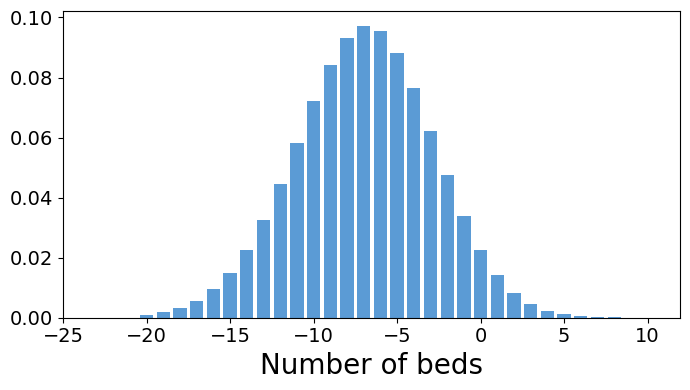

In [19]:


prob_dist_plot(prob_dist_data=netposition_demand.sort_index().loc[-20:20], title='Net position', 
                   directory_path=Path('/home/jovyan/work/patientflow/notebooks/img/supply_demand_examples'), 
               figsize=(7,4), 
               text_size=20,                    
               file_name = 'Net_position_demand', 
                   truncate_at_beds = (-25, 10),
                  bar_colour = spec_colour_dict['single']['paediatric'])

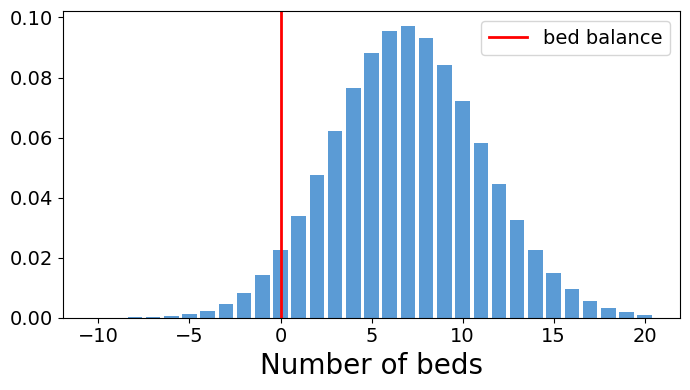

In [62]:
# Assuming bed base is 16
bedbase = netposition.copy(deep = True)
bedbase.index = bedbase.index + 16 -22

min_beds_lines = {}
cdf_cut_points=[0.7, 0.9]

for cut_point in cdf_cut_points: 
    min_beds_lines[cut_point] = index_of_sum(netposition.sort_index().values, cut_point)

prob_dist_plot(prob_dist_data=netposition.sort_index(), title='Bed base with line at zero', 
                   directory_path=directory_path, 
               figsize=(7,4), 
               text_size=20,                    # file_name = 'Figure c', 
                   truncate_at_beds = (-10, 20),
                              plot_bed_base = [0],
               # min_beds_lines=min_beds_lines,
                  bar_colour = spec_colour_dict['single']['paediatric'])


In [11]:
??prob_dist_plot

Signature:
prob_dist_plot(
    prob_dist_data,
    title,
    directory_path=None,
    figsize=(6, 3),
    include_titles=False,
    truncate_at_beds=(0, 20),
    text_size=None,
    bar_colour='#5B9BD5',
    file_name=None,
    min_beds_lines=None,
    plot_min_beds_lines=True,
    plot_bed_base=None,
)
Docstring: <no docstring>
Source:   
def prob_dist_plot(
    prob_dist_data,
    title,
    directory_path=None,
    figsize=(6, 3),
    include_titles=False,
    truncate_at_beds=(0, 20),
    text_size=None,
    bar_colour="#5B9BD5",
    file_name=None,
    min_beds_lines=None,
    plot_min_beds_lines=True,
    plot_bed_base=None,
):
    plt.figure(figsize=figsize)
    if not file_name:
        file_name = (
            title.replace(" ", "_").replace("/n", "_").replace("%", "percent") + ".png"
        )

    if isinstance(truncate_at_beds, (int, float)):
        upper_bound = truncate_at_beds
        lower_bound = 0
    else:
        lower_bound, upper_bound = truncate_at_beds
      